In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from PIL import Image
import numpy as np
from noise_scheduler import LinearNoiseScheduler
from torch.utils.data import Dataset
import os
from torch.utils.data import DataLoader
import pandas as pd



In [2]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Time embeddings
        self.time_mlp = nn.Sequential(
            nn.Linear(1, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
        )

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.GroupNorm(8, 64),
            nn.SiLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.GroupNorm(8, 64),
            nn.SiLU(),
        )
        self.down1 = nn.Conv2d(64, 64, 4, stride=2, padding=1)   # 16 → 8

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.GroupNorm(8, 128),
            nn.SiLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.GroupNorm(8, 128),
            nn.SiLU(),
        )
        self.down2 = nn.Conv2d(128, 128, 4, stride=2, padding=1) # 8 → 4

        # Bottleneck
        self.mid = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.GroupNorm(8, 256),
            nn.SiLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.GroupNorm(8, 256),
            nn.SiLU(),
        )

        # Decoder
        self.up1 = nn.Upsample(scale_factor=2, mode="nearest")   # 4 → 8
        self.dec1 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, 3, padding=1),
            nn.GroupNorm(8, 128),
            nn.SiLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.GroupNorm(8, 128),
            nn.SiLU(),
        )

        self.up2 = nn.Upsample(scale_factor=2, mode="nearest")   # 8 → 16
        self.dec2 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, 3, padding=1),
            nn.GroupNorm(8, 64),
            nn.SiLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.GroupNorm(8, 64),
            nn.SiLU(),
        )

        # Output
        self.out = nn.Conv2d(64, 3, 1)

    def forward(self, x, t):
        # Timestep embedding
        t = t.float().unsqueeze(1)
        t_emb = self.time_mlp(t)

        # Encoder
        e1 = self.enc1(x)
        e1 = e1 + t_emb[:, :64, None, None]

        x = self.down1(e1)

        e2 = self.enc2(x)
        e2 = e2 + t_emb[:, :128, None, None]

        x = self.down2(e2)

        # Bottleneck
        x = self.mid(x)
        x = x + t_emb[:, :256, None, None]

        # Decoder
        x = self.up1(x)
        x = torch.cat([x, e2], dim=1)
        x = self.dec1(x)
        x = x + t_emb[:, :128, None, None]

        x = self.up2(x)
        x = torch.cat([x, e1], dim=1)
        x = self.dec2(x)
        x = x + t_emb[:, :64, None, None]

        return self.out(x)

In [3]:
df = pd.read_csv("data/labels.csv")

In [4]:
image_dir = "data/images/images"
image_paths = [
    os.path.join(image_dir, f).split("/")[3].split(".")[0]
    for f in os.listdir(image_dir)
]

In [5]:
first_label_paths = df[df["Label"] == "[1. 0. 0. 0. 0.]"]["Image Path"].tolist()

In [6]:
filtered_paths = [i.split("/")[2].split(".")[0] for i in first_label_paths]

In [7]:
image_paths = [
            os.path.join(image_dir, f).split("/")[3].split(".")[0]
            for f in os.listdir(image_dir)
            if os.path.join(image_dir, f).split("/")[3].split(".")[0] in filtered_paths
        ]

In [8]:
len(image_paths)

8000

In [9]:
class ImageFolderDataset(Dataset):
    def __init__(self, image_dir):
        self.image_paths = [
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir)
            if os.path.join(image_dir, f).split("/")[3].split(".")[0] in filtered_paths
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        img = np.array(img)

        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        img = img * 2 - 1         

        return img


In [10]:
def q_sample(x0, t, scheduler):
    noise = torch.randn_like(x0)

    sqrt_ab = scheduler.sqrt_alpha_cum_prod[t][:, None, None, None]
    sqrt_omab = scheduler.sqrt_one_minus_alpha_cum_prod[t][:, None, None, None]

    x_t = sqrt_ab * x0 + sqrt_omab * noise
    return x_t, noise

def diffusion_loss(model, x0, scheduler):
    B = x0.size(0)
    device = x0.device

    t = torch.randint(0, scheduler.num_timesteps, (B,), device=device)

    x_t, noise = q_sample(x0, t, scheduler)
    pred_noise = model(x_t, t)

    return F.mse_loss(pred_noise, noise)

def train_diffusion(
    model,
    dataloader,
    epochs,
    lr=1e-4,
    num_timesteps=100,
    device="mps"
):
    model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    scheduler = LinearNoiseScheduler(
        num_timesteps=num_timesteps,
        beta_start=1e-4,
        beta_end=0.02
        )
    
    scheduler.betas = scheduler.betas.to(device)
    scheduler.alphas = scheduler.alphas.to(device)
    scheduler.alpha_cum_prod = scheduler.alpha_cum_prod.to(device)
    scheduler.sqrt_alpha_cum_prod = scheduler.sqrt_alpha_cum_prod.to(device)
    scheduler.sqrt_one_minus_alpha_cum_prod = scheduler.sqrt_one_minus_alpha_cum_prod.to(device)

    for epoch in range(epochs):
        total_loss = 0.0

        for i, images in enumerate(dataloader):
            images = images.to(device)

            loss = diffusion_loss(model, images, scheduler)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.6f}")

In [ ]:
model = UNet()

dataset = ImageFolderDataset("data/images/images")
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True
)

print("Starting train")
train_diffusion(
    model=model,
    dataloader=dataloader,
    epochs=50,
    lr=1e-4,
    num_timesteps=75,
    device="mps" 
)

Starting train
Epoch [1/50] | Loss: 1.413956
Epoch [2/50] | Loss: 0.556412
Epoch [3/50] | Loss: 0.316219
Epoch [4/50] | Loss: 0.266237
Epoch [5/50] | Loss: 0.237790
Epoch [6/50] | Loss: 0.216530
Epoch [7/50] | Loss: 0.197195
Epoch [8/50] | Loss: 0.182830
Epoch [9/50] | Loss: 0.171435
Epoch [10/50] | Loss: 0.154507
Epoch [11/50] | Loss: 0.149378
Epoch [12/50] | Loss: 0.134369
Epoch [13/50] | Loss: 0.126591
Epoch [14/50] | Loss: 0.118167
Epoch [15/50] | Loss: 0.111472
Epoch [16/50] | Loss: 0.104754
Epoch [17/50] | Loss: 0.100694
Epoch [18/50] | Loss: 0.091670
Epoch [19/50] | Loss: 0.089166
Epoch [20/50] | Loss: 0.086923
Epoch [21/50] | Loss: 0.084750
Epoch [22/50] | Loss: 0.080305
Epoch [23/50] | Loss: 0.078105
Epoch [24/50] | Loss: 0.073679
Epoch [25/50] | Loss: 0.072449
Epoch [26/50] | Loss: 0.070267
Epoch [27/50] | Loss: 0.067304
Epoch [28/50] | Loss: 0.064411
Epoch [29/50] | Loss: 0.065358
Epoch [30/50] | Loss: 0.061521
Epoch [31/50] | Loss: 0.062645
Epoch [32/50] | Loss: 0.060817
Ep

In [54]:
@torch.no_grad()
def sample(
    model,
    scheduler,
    image_size=16,
    device="mps"
):
    model.eval()

    x = torch.randn(1, 3, image_size, image_size, device=device)

    for t in reversed(range(scheduler.num_timesteps)):
        t_tensor = torch.tensor([t], device=device)

        pred_noise = model(x, t_tensor)

        alpha = scheduler.alphas[t]
        alpha_bar = scheduler.alpha_cum_prod[t]
        beta = scheduler.betas[t]

        x = (1 / torch.sqrt(alpha)) * (
            x - (beta / torch.sqrt(1 - alpha_bar)) * pred_noise
        )

        if t > 0:
            noise = torch.randn_like(x)
            x = x + torch.sqrt(beta) * noise

    return x

In [55]:
scheduler = LinearNoiseScheduler(
    num_timesteps=100,
    beta_start=1e-4,
    beta_end=0.02
    )

In [82]:
device = "mps"  # or cuda

model.eval()


sampled = sample(model, scheduler, image_size=16, device=device)

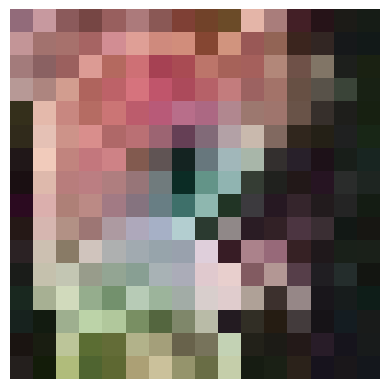

In [83]:
import matplotlib.pyplot as plt

img = sampled.squeeze(0)
img = (img + 1) / 2         
img = img.clamp(0, 1)
img = img.permute(1, 2, 0).cpu().numpy()

plt.imshow(img)
plt.axis("off")
plt.show()